# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 

## Homework 8: Ensembles: Bagging, Random Forests, and Boosting


**Harvard University**<br/>
**Fall 2018**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader

<hr style="height:2pt">



In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the [instructions given in Canvas](https://canvas.harvard.edu/courses/42693/pages/homework-policies-and-submission-instructions).

- If needed, clarifications will be posted on Piazza.

- This homework can be submitted in pairs.

- If you submit individually but you have worked with someone, please include the name of your **one** partner below. 


**Name of the person you have worked with goes here:**
<br><BR>

## Learning Objectives
Completing this assignment will demonstrate success at the following objectives:

- Statistical
  - Predict when bagging will help model performance.
  - Identify how Random Forests improve over bagging.
  - Predict when boosting will help model performance.
  - Compare and contrast bagging and boosting.
- Coding
  - Identify and fix problems in poorly written code
- Communication
  - Visually explain a complex concept

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

<div class="theme"> Overview: Higgs Boson Discovery </div>

The discovery of the Higgs boson in July 2012 marked a fundamental breakthrough in particle physics. The Higgs boson particle was discovered through experiments at the Large Hadron Collider at CERN, by colliding beams of protons at high energy. A key challenge in analyzing the results of these experiments is to differentiate between collisions that produce Higgs bosons and collisions that produce only background noise. We shall explore the use of ensemble methods for this classification task.

You are provided with data from Monte-Carlo simulations of collisions of particles in a particle collider experiment. The training set is available in `Higgs_train.csv` and the test set is in `Higgs_test.csv`. Each row in these files corresponds to a particle collision described by 28 features (columns 1-28), of which the first 21 features are kinematic properties measured by the particle detectors in the accelerator, and the remaining features are derived by physicists from the first 21 features. The class label is provided in the last column, with a label of 1 indicating that the collision produces Higgs bosons (signal), and a label of 0 indicating that the collision produces other particles (background).

The data set provided to you is a small subset of the HIGGS data set in the UCI machine learning repository. The following paper contains further details about the data set and the predictors used: [Baldi et al., Nature Communications 5, 2014](https://www.nature.com/articles/ncomms5308).

In [3]:
# Load data
data_train = pd.read_csv('data/Higgs_train.csv')
data_test = pd.read_csv('data/Higgs_test.csv')

print(f"{len(data_train)} training samples, {len(data_test)} test samples")
print("\nColumns:")
print(', '.join(data_train.columns))

5000 training samples, 5000 test samples

Columns:
lepton pT, lepton eta, lepton phi, missing energy magnitude, missing energy phi, jet 1 pt, jet 1 eta, jet 1 phi, jet 1 b-tag, jet 2 pt, jet 2 eta, jet 2 phi, jet 2 b-tag, jet 3 pt, jet 3 eta, jet 3 phi, jet 3 b-tag, jet 4 pt, jet 4 eta, jet 4 phi, jet 4 b-tag, m_jj, m_jjj, m_lv, m_jlv, m_bb, m_wbb, m_wwbb, class


In [4]:
display(data_train.head())
display(data_train.describe())

lepton pT  lepton eta  lepton phi  missing energy magnitude  missing energy phi  jet 1 pt  jet 1 eta  jet 1 phi  jet 1 b-tag  jet 2 pt  jet 2 eta  jet 2 phi  jet 2 b-tag  jet 3 pt  jet 3 eta  jet 3 phi  jet 3 b-tag  jet 4 pt  jet 4 eta  jet 4 phi  jet 4 b-tag   m_jj  m_jjj   m_lv  m_jlv   m_bb  m_wbb  m_wwbb  class
0      0.377     -1.5800     -1.7100                     0.991               0.114     1.250      0.620     -1.480         2.17     0.754     0.7750     -0.667         2.21     1.280     -1.190      0.505         0.00     1.110     -0.464      0.397         0.00  0.522  1.320  0.982  1.360  0.965  1.310   1.080    1.0
1      0.707      0.0876     -0.4000                     0.919              -1.230     1.170     -0.553      0.886         2.17     1.300     0.7620     -1.060         2.21     0.607      0.459      1.020         0.00     0.497      0.956      0.236         0.00  0.440  0.829  0.992  1.160  2.220  1.190   0.938    1.0
2      0.617      0.2660     -1.3500                     1.150               1.040     0.955      0.377     -0.148         0.00     1.060    -0.0194      1.110         0.00     1.470      0.205     -1.060         2.55     1.490     -0.398     -0.542         0.00  1.020  1.030  0.986  0.928  1.370  0.982   0.917    1.0
3      0.851     -0.3810     -0.0713                     1.470              -0.795     0.692      0.883      0.497         0.00     1.620     0.1240      1.180         1.11     1.290      0.160     -0.916         2.55     0.945      0.796     -1.520         0.00  1.200  1.100  0.987  1.350  1.460  0.995   0.954    1.0
4      0.768     -0.6920     -0.0402                     0.615               0.144     0.749      0.397     -0.874         0.00     1.150     0.1270      1.320         2.21     0.730     -0.758     -1.120         0.00     0.848      0.107      0.502         1.55  0.922  0.864  0.983  1.370  0.601  0.919   0.957    0.0

lepton pT   lepton eta   lepton phi  missing energy magnitude  missing energy phi     jet 1 pt    jet 1 eta    jet 1 phi  jet 1 b-tag     jet 2 pt    jet 2 eta    jet 2 phi  jet 2 b-tag     jet 3 pt    jet 3 eta    jet 3 phi  jet 3 b-tag     jet 4 pt    jet 4 eta    jet 4 phi  jet 4 b-tag         m_jj        m_jjj         m_lv        m_jlv         m_bb        m_wbb       m_wwbb        class
count  5000.000000  5000.000000  5000.000000               5000.000000         5000.000000  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000
mean      0.978645    -0.014280    -0.018956                  1.005793            0.002528     0.980390     0.025014    -0.007104     0.993678     0.988659    -0.010310    -0.006926     1.006922     0.997004     0.018817     0.003952     1.011994     0.982806     0.005201     0.003349     1.007810     1.038431     1.027201     1.054719     1.023094     0.958464     1.033432     0.960494     0.524600
std       0.547025     1.011927     0.997945                  0.591907            1.003337     0.463677     1.002018     1.014559     1.028920     0.476462     1.007983     1.002177     1.045206     0.471681     1.007824     0.999656     1.200416     0.497681     1.007999     1.008904     1.400846     0.619460     0.353984     0.173243     0.427141     0.495720     0.352966     0.306057     0.499444
min       0.275000    -2.410000    -1.740000                  0.010000           -1.740000     0.170000    -2.920000    -1.740000     0.000000     0.198000    -2.910000    -1.740000     0.000000     0.265000    -2.720000    -1.740000     0.000000     0.366000    -2.500000    -1.740000     0.000000     0.151000     0.443000     0.339000     0.371000     0.079500     0.413000     0.452000     0.000000
25%       0.587000    -0.764250    -0.877500                  0.581000           -0.870000     0.676000    -0.659250    -0.885000     0.000000     0.666000    -0.699000    -0.859500     0.000000     0.664750    -0.679250    -0.858000     0.000000     0.619000    -0.707250    -0.869250     0.000000     0.798750     0.850000     0.986000     0.768000     0.672000     0.826000     0.772750     0.000000
50%       0.846000    -0.009305    -0.016050                  0.903500            0.001300     0.891000     0.049500    -0.023500     1.090000     0.891000    -0.004800    -0.030700     1.110000     0.899500     0.045700     0.018800     0.000000     0.877000     0.012900    -0.004700     0.000000     0.898000     0.957000     0.990000     0.922000     0.868000     0.952000     0.877500     1.000000
75%       1.220000     0.725500     0.837000                  1.300000            0.866000     1.160000     0.716000     0.894000     2.170000     1.192500     0.692250     0.855500     2.210000     1.232500     0.717000     0.855000     2.550000     1.220000     0.719000     0.859000     3.100000     1.030000     1.090000     1.030000     1.160000     1.120000     1.140000     1.060000     1.000000
max       5.330000     2.430000     1.740000                  6.260000            1.740000     4.190000     2.960000     1.740000     2.170000     4.800000     2.910000     1.740000     2.210000     4.630000     2.730000     1.740000     2.550000     5.770000     2.490000     1.740000     3.100000    10.600000     5.740000     3.940000     6.220000     5.080000     4.320000     3.500000     1.000000

In [5]:
# Split into NumPy arrays
X_train = data_train.iloc[:, data_train.columns != 'class'].values
y_train = data_train['class'].values
X_test = data_test.iloc[:, data_test.columns != 'class'].values
y_test = data_test['class'].values

<div class="exercise"> <b> Question 1: A Single Model [20 pts]</b> </div>

We start by fitting a basic model we can compare the other models to. We'll pick a decision tree as the base model, because we'll later include random forests and want a fair comparison. We'll tune the decision tree using cross-validation. As usual, we'll be tuning the maximum tree depth; we refer to this parameter as "depth" for simplicity.

Since we will only be using tree-based methods in this homework, we do not need to standardize or normalize the predictors.



**1.1**: Fit a decision tree model to the training set. Choose a range of tree depths to evaluate. Plot the estimated performance +/- 2 standard deviations for each depth using 5-fold cross validation. Also include the training set performance in your plot, but set the y-axis to focus on the cross-validation performance.

*Hint*: use `plt.fill_between` to shade the region.

**1.2** Select an appropriate depth and justify your choice. Using your cross-validation estimates, report the mean +/- 2 stdev. Then report the classification accuracy on the test set. (Store the training and test accuracies in variables to refer to in a later question.)

**1.3** What is the mechanism by which limiting the depth of the tree avoids over-fitting? What is one downside of limiting the tree depth? Your answer should refer to the bias-variance trade-off.

# Solution

**1.1**

In [6]:
#Perform 5-fold cross validation and store results
depths = list(range(1, 21))
train_scores, cvmeans, cvstds, cv_scores = [], [], [], []
for depth in depths:
    clf = DecisionTreeClassifier(max_depth=depth)
    train_scores.append(clf.fit(X_train, y_train).score(X_train, y_train))
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=5)
    cvmeans.append(scores.mean())
    cvstds.append(scores.std())

#Alter data structure for using internal numpy functions
cvmeans = np.array(cvmeans)
cvstds = np.array(cvstds)

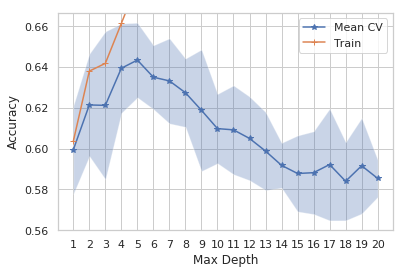

In [7]:
#Plot Means and Shade the +-2 SD Interval
plt.plot(depths, cvmeans, '*-', label="Mean CV")
plt.fill_between(depths, cvmeans - 2*cvstds, cvmeans + 2*cvstds, alpha=0.3)
ylim = plt.ylim()
plt.plot(depths, train_scores, '-+', label="Train")
plt.ylim(ylim)
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Max Depth")
plt.xticks(depths)
plt.show()

**1.2**

In [8]:
#Choosing the best depth
idx = depths.index(5)
print("Accuracy: Mean={:.3f}, +/- 2 SD: [{:.3f} -- {:.3f}]".format(
    cvmeans[idx], cvmeans[idx] - 2*cvstds[idx], cvmeans[idx] + 2*cvstds[idx]))

Accuracy: Mean=0.643, +/- 2 SD: [0.625 -- 0.662]


Although depth 5 has the highest CV score, there isn't enough evidence in the cross validation to distinguish it from depths of 4, 6, or even 7. You could justifiably pick any of these values, reasoning that 4 will give a simpler model that's less likely to overfit, or that the full model will be trained on 20% more data than the CV models and might support a greater depth. We'll pick depth=5.

In [9]:
#Evaluate performance on Test Set
best_cv_depth = 5
fitted_tree = DecisionTreeClassifier(max_depth=best_cv_depth).fit(X_train, y_train)
best_cv_tree_train_score = fitted_tree.score(X_train, y_train)
best_cv_tree_test_score = fitted_tree.score(X_test, y_test)
print(f"The tree of depth {best_cv_depth} achieved an Accuracy of {best_cv_tree_test_score:.3f} on the test set.")

The tree of depth 5 achieved an Accuracy of 0.648 on the test set.


**1.3**

The bias-variance dilemma is very signinficant. The bias of a model quantifies how precise a model is across training sets. The variance quantifies how sensitive the model is to small changes in the training set. A robust model is not overly sensitive to small changes. The dilemma involves minimizing both bias and variance; we want a precise and robust model. Simpler models tend to be less accurate but more robust. Complex models tend to be more accurate but less robust.

In Decision trees, limiting the depth will limit the ability of the model to explore the crevaces of the problem and make extremely sharp cuts around the datapoints of the training set for classification. This increases generalizability of the model and prevents overfitting. However, the limitation is clear, it prevents the model from achieving maximum accuracy.

**For students :**

Consider the following example, in face recognition algorithms, such as that on the iPhone X, a too-accurate model would be unable to identity someone who styled their hair differently that day. The reason is that our model may learn irrelevant features in the training data. On the contrary, an insufficiently trained model would not generalize well either. For example, it was recently reported that a face mask could sufficiently fool the iPhone X.

<div class="exercise"> <b> Question 2: Bagging [25 pts]</b> </div>

Bagging is the technique of building the same model on multiple bootstraps from the data and combining each model's prediction to get an overall classification. In this question we build an example by hand and study how the number of bootstrapped datasets impacts the accuracy of the resulting classification.



**2.1** Choose a tree depth that will overfit the training set. What evidence leads you to believe that this depth will overfit? Assign your choice to a variable here. (You may want to explore different settings for this value in the problems below.)

**2.2** Create 45 bootstrapped replications of the original training data, and fit a decision tree to each. Use the tree depth you just chose in 2.1. Record each tree's prediction. In particular, produce a dataset like those below, where each row is a training (or test) example, each column is one of the trees, and each entry is that tree's prediction for that example. (Labeling the rows and columns is optional.)

Store these results as `bagging_train` and `bagging_test`. Don't worry about visualizing these results yet.

**2.3** _Aggregate_ all 45 _bootstrapped_ models to get a combined prediction for each training and test point: predict a 1 if and only if a majority of the models predict that example to be from class 1. What accuracy does this *bagging* model achieve on the test set? Write an assertion that verifies that this test-set accuracy is at least as good as the accuracy for the model you fit in Question 1.

**2.4** We want to know how the number of bootstraps affects our bagging ensemble's performance. Use the `running_predictions` function (given below) to get the model's accuracy score when using only 1,2,3,4,... of the bootstrapped models. Make a plot of training and test set accuracies as a function of number of bootstraps.

On your plot, also include horizontal lines for two baselines:
- the test accuracy of the best model from question 1
- the test accuracy of a single tree with the tree depth you chose in 2.1, trained on the full training set.

**2.5** Referring to your graph from 2.4, compare the performance of bagging against the baseline of a single depth-10 tree. Explain the differences you see.

**2.6** Bagging and limiting tree depth both affect how much the model overfits. Compare and contrast these two approaches. Your answer should refer to your graph in 2.4 and may duplicate something you said in your answer to 1.5.

**2.7**: In what ways might our bagging classifier be overfitting the data? In what ways might it be underfitting?

**Hints**
- Use `resample` from sklearn to easily bootstrap the x and y data.
- use `np.mean` to easily test for majority. If a majority of models vote 1, what does that imply about the mean?

# Solution 

**2.1**

**Your answer here**


In [10]:
#Select overfit tree depth
tree_depth = 20

**2.2**

**Structure of `bagging_train` and `bagging_test`:**

`bagging_train`:

|     |bootstrap model 1's prediction|bootstrap model 2's prediction|...|bootstrap model 45's prediction|
| --- | --- | --- | --- |
|training row 1| binary value | binary value|... |binary value|
|training row 2| binary value| binary value|... |binary value|
|...| ...| ...|... |... |

`bagging_test`:

|     |bootstrap model 1's prediction|bootstrap model 2's prediction|...|bootstrap model 45's prediction|
| --- | --- | --- | --- |
|test row 1| binary value | binary value|... |binary value|
|test row 2| binary value| binary value|... |binary value|
|...| ...| ...|... |... |


In [11]:
#Set number of trees
n_trees = 45

#Conduct bootstrapping and fit models to the date
np.random.seed(0)
bagging_train = np.zeros((X_train.shape[0], n_trees))
bagging_test = np.zeros((X_test.shape[0], n_trees))
bagging_models = []
for i in range(n_trees):
    bootstrapped_X, bootstrapped_y = resample(X_train, y_train)
    fitted_model = DecisionTreeClassifier(max_depth=tree_depth).fit(bootstrapped_X, bootstrapped_y)
    bagging_models.append(fitted_model)
    bagging_train[:,i] = fitted_model.predict(X_train)
    bagging_test[:,i] = fitted_model.predict(X_test)

#Create dataframe of model predictions
pd.DataFrame(bagging_train, columns=[f"model{x}" for x in range(n_trees)]).head()

model0  model1  model2  model3  model4  model5  model6  model7  model8  model9  model10  model11  model12  model13  model14  model15  model16  model17  model18  model19  model20  model21  model22  model23  model24  model25  model26  model27  model28  model29  model30  model31  model32  model33  model34  model35  model36  model37  model38  model39  model40  model41  model42  model43  model44
0     1.0     1.0     1.0     1.0     0.0     0.0     1.0     0.0     1.0     1.0      1.0      1.0      0.0      1.0      1.0      1.0      1.0      0.0      1.0      0.0      1.0      1.0      1.0      0.0      1.0      1.0      1.0      1.0      1.0      1.0      1.0      0.0      1.0      1.0      1.0      1.0      1.0      1.0      0.0      0.0      1.0      1.0      1.0      1.0      1.0
1     0.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0     0.0     0.0      1.0      1.0      1.0      1.0      0.0      1.0      1.0      1.0      1.0      1.0      1.0      1.0      1.0      1.0      1.0      0.0      1.0      0.0      0.0      0.0      1.0      0.0      1.0      1.0      1.0      1.0      1.0      0.0      1.0      1.0      1.0      1.0      1.0      1.0      1.0
2     1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0      1.0      1.0      1.0      1.0      1.0      0.0      0.0      1.0      1.0      0.0      1.0      1.0      0.0      1.0      0.0      1.0      1.0      1.0      1.0      1.0      0.0      1.0      1.0      1.0      1.0      1.0      1.0      1.0      1.0      0.0      1.0      1.0      1.0      1.0      1.0
3     1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0     0.0     0.0      1.0      1.0      1.0      1.0      1.0      1.0      1.0      1.0      1.0      1.0      1.0      1.0      1.0      1.0      1.0      1.0      1.0      1.0      1.0      1.0      1.0      1.0      0.0      1.0      1.0      1.0      1.0      0.0      1.0      1.0      1.0      0.0      0.0      0.0      1.0
4     0.0     0.0     0.0     0.0     0.0     0.0     0.0     1.0     1.0     0.0      0.0      0.0      0.0      0.0      0.0      1.0      1.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      1.0      1.0      0.0      0.0      0.0      0.0      0.0      0.0      1.0      0.0      1.0      0.0      0.0

**2.3**

In [12]:
#Get Predictions across all models
bagging_train_predictions = np.mean(bagging_train, axis=1) > .5
bagging_test_predictions = np.mean(bagging_test, axis=1) > .5

#Calculate Accuracy
bagging_accuracy_train = np.mean(bagging_train_predictions == y_train)
bagging_accuracy_test = np.mean(bagging_test_predictions == y_test)
print(f"Bagging {n_trees} trees, each of depth {tree_depth}, achieved a score of {bagging_accuracy_train:.3f} on the training set.")
print(f"Bagging {n_trees} trees, each of depth {tree_depth}, achieved a score of {bagging_accuracy_test:.3f} on the test set.")
assert bagging_accuracy_test >= best_cv_tree_test_score

Bagging 45 trees, each of depth 20, achieved a score of 1.000 on the training set.
Bagging 45 trees, each of depth 20, achieved a score of 0.682 on the test set.


**2.4**

In [13]:
def running_predictions(prediction_dataset, targets):
    """A function to predict examples' class via the majority among trees (ties are predicted as 0)
    
    Inputs:
      prediction_dataset - a (n_examples by n_sub_models) dataset, where each entry [i,j] is sub-model j's prediction
          for example i
      targets - the true class labels
    
    Returns:
      a vector where vec[i] is the model's accuracy when using just the first i+1 sub-models
    """
    
    n_trees = prediction_dataset.shape[1]
    
    # find the running percentage of models voting 1 as more models are considered
    running_percent_1s = np.cumsum(prediction_dataset, axis=1)/np.arange(1,n_trees+1)
    
    # predict 1 when the running average is above 0.5
    running_conclusions = running_percent_1s > 0.5
    
    # check whether the running predictions match the targets
    running_correctnesss = running_conclusions == targets.reshape(-1,1)
    
    return np.mean(running_correctnesss, axis=0)
    # returns a 1-d series of the accuracy of using the first n trees to predict the targets

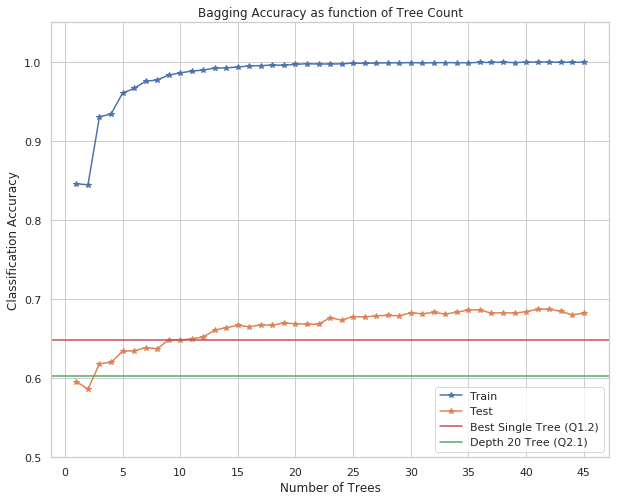

In [14]:
#Generate plot to evaluate variation of accuracy as function of Tree Count
single_tree = DecisionTreeClassifier(max_depth=tree_depth).fit(X_train, y_train)
single_tree_train_score = single_tree.score(X_train, y_train)
single_tree_test_score = single_tree.score(X_test, y_test)
train_history = running_predictions(bagging_train, y_train)
test_history = running_predictions(bagging_test, y_test)

plt.figure(figsize=(10, 8))
plt.plot(range(1,n_trees+1),train_history,'*-',label='Train')
plt.plot(range(1,n_trees+1),test_history,'*-',label='Test')
plt.ylim(.5,1.05)
plt.xticks(np.arange(0, n_trees + 1, 5))
plt.xlabel("Number of Trees")
plt.ylabel("Classification Accuracy")
plt.title("Bagging Accuracy as function of Tree Count")
plt.axhline(best_cv_tree_test_score, color='r', label="Best Single Tree (Q1.2)")
plt.axhline(single_tree_test_score, color='g', label=f"Depth {tree_depth} Tree (Q2.1)")
plt.legend()
plt.show()

**2.5**

The Bagging model has less variance and is thus less sensitive to changes in the data. This can be seen by the superior test/validation set performance. Bagging, as a technique, was able to reduce the variance of a Depth-20, highly overfit decision tree model to higher than that of Depth-10 model by using as less as 5 trees, as seen from the graph in 2.4.


**2.6**

- Both reduce overfitting by reducing variance.
- Limiting tree depth makes model less expressive -> lower performance.
- Bagging averages somewhat-independent estimates.

**2.7**

* Overfitting : Training set may still not be representative. Estimates are still highly correlated, since trees have similar structure.

* Underfitting :  Base learners are only depth-X trees. Still has bias against, e.g., slanted or curved decision boundaries.

<div class="exercise"> <b> Question 3: Random Forests [15 pts]</b> </div>

Random Forests are closely related to the bagging model we built by hand in question 2. In this question we compare our by-hand results with the results of using `RandomForestClassifier` directly.



**3.1** Fit a `RandomForestClassifier` to the original `X_train` data using the same tree depth and number of trees that you used in Question 2.2. Evaluate its accuracy on the test set.

**3.2** For each of the decision trees you fit in the bagging process, how many times is each feature used at the top node? How about for each tree in the random forest you just fit? What about the process of training the Random Forest causes this difference? What implication does this observation have on the accuracy of bagging vs Random Forest?

**Hint**: A decision tree's top feature is stored in `model.tree_.feature[0]`. A random forest object stores its decision trees in its `.estimators_` attribute.

**3.3**: Make a table of the training and test accuracy for the following models:

- Single tree with best depth chosen by cross-validation (from Question 1)
- A single overfit tree trained on all data (from Question 2, using the depth you chose there)
- Bagging 45 such trees (from Question 2)
- A Random Forest of 45 such trees (from Question 3.1)

(This problem should not require fitting any new models, though you may need to go back and store the accuracies from models you fit previously.)

What is the relative performance of each model on the training set? On the test set? Comment on how these relationships make sense (or don't make sense) in light of how each model treats the bias-variance trade-off.

# Solution

**3.1**

In [15]:
#Fit a Random Forest model
fitted_rf = RandomForestClassifier(n_estimators=n_trees, max_depth=tree_depth).fit(X_train,y_train)
random_forest_train_score = fitted_rf.score(X_train, y_train)
random_forest_test_score = fitted_rf.score(X_test, y_test)
print(f"The Random Forest scored {random_forest_train_score:.3f} on the training set.")
print(f"The Random Forest scored {random_forest_test_score:.3f} on the test set.")

The Random Forest scored 1.000 on the training set.
The Random Forest scored 0.685 on the test set.


**3.2**

In [16]:
#Compare feature to top node count for both Bagging and Random Forest
print("Bagging Feature vs Top Node Count :")
display(pd.Series([model.tree_.feature[0] for model in bagging_models]).value_counts())
print("Random Forest Feature vs Top Node Count :")
display(pd.Series([model.tree_.feature[0] for model in fitted_rf.estimators_]).value_counts())

Bagging Feature vs Top Node Count :


25    45
dtype: int64

Random Forest Feature vs Top Node Count :


25    12
26     8
27     4
3      4
24     3
22     2
12     2
9      2
5      2
0      2
14     1
13     1
10     1
1      1
dtype: int64

Random Forest takes a random subset of predictors at each split which reduces the likelihood of overfitting and creates a diverse (less correlated) set of trees. We see that the performance of Random Forest on the test set is slightly higher than Bagging since intuitively the model is generalizing better.

**Note**: a common misconception was that RF's pick a different set of features for each estimator. Actually, they pick a different set of features at each *split*. For our trees, each estimator ends up using every one of the 29 features:

In [27]:
# sklearn uses feature=-2 to indicate something special, probably an incomplete tree... filter that out.
pd.Series(
    [len(set(feat_idx for feat_idx in model.tree_.feature if feat_idx >= 0))
     for model in fitted_rf.estimators_]).value_counts()

28    45
dtype: int64

In [26]:
X_train.shape[1]

28

**3.3**

Fill in the following table (ideally in code, but ok to fill in this Markdown cell).


| classifier | training accuracy | test accuracy |
| --- | --- | --- |
| single tree with best depth chosen by CV | | |
| single depth-X tree | | |
| bagging 45 depth-X trees | | |
| Random Forest of 45 depth-X trees | | |

In [17]:
#Create dataframe for comparison of performance
pd.DataFrame([
    ('Single Tree with best Depth chosen by CV', best_cv_tree_train_score, best_cv_tree_test_score),
    (f"Single Depth-{tree_depth} Tree", single_tree_train_score, single_tree_test_score),
    (f'Bagging {n_trees} Fepth-{tree_depth} Trees', bagging_accuracy_train, bagging_accuracy_test),
    (f'Random Forest of {n_trees} Depth-{tree_depth} Trees', random_forest_train_score, random_forest_test_score)
], columns=["Classifier", "Training Accuracy", "Test Accuracy"]).set_index('Classifier')

Training Accuracy  Test Accuracy
Classifier                                                                
Single Tree with best Depth chosen by CV             0.6812         0.6478
Single Depth-20 Tree                                 1.0000         0.6024
Bagging 45 Fepth-20 Trees                            0.9996         0.6822
Random Forest of 45 Depth-20 Trees                   0.9996         0.6854

The single Depth-5 tree underfits the training set: it only gets 68%, while the Depth-20 trees get a perfect (or nearly perfect) score. The single Depth-20 tree overfits badly (perfect performance on train, bad performance on test). However, Bagging 45 such trees gives a better accuracy than the Depth-5 tree: each individual tree is more expressive (lower bias), and averaging many trees' predictions mitigates the increased variance. The Random Forest model performs even slightly better, which is unsurprising since each of the predictions it averages together are less correlated.

<div class="exercise"> <b> Question 4: Boosting [15 pts]</b> </div>

In this question we explore a different kind of ensemble method, boosting, where each new model is trained on a dataset weighted towards observations that the current set of models predicts incorrectly. 

We'll focus on the AdaBoost flavor of boosting and examine what happens to the ensemble model's accuracy as the algorithm adds more predictors to the ensemble.



**4.1** We'll motivate AdaBoost by noticing patterns in the errors that a single classifier makes. Fit `tree1`, a decision tree with depth 3, to the training data. For each predictor, make a plot that compares two distributions: the values of that predictor for examples that `tree1` classifies correctly, and the values of that predictor for examples that `tree1` classifies incorrectly. Do you notice any predictors for which the distributions are clearly different?

**4.2** The following code attempts to implement a simplified version of boosting using just two classifiers (described below). However, it has both stylistic and functionality flaws. First, imagine that you are a grader for a Data Science class; write a comment for the student who submitted this code. Then, imagine that you're the TF writing the solutions; make an excellent example implementation. Finally, use your corrected code to compare the performance of `tree1` and the boosted algorithm on both the training and test set.

**4.3** Now let's use the sklearn implementation of AdaBoost: Use `AdaBoostClassifier` to fit another ensemble to `X_train`. Use a decision tree of depth 3 as the base learner and a learning rate 0.05, and run the boosting for 800 iterations. Make a plot of the effect of the number of estimators/iterations on the model's train and test accuracy.

*Hint*: The `staged_score` method provides the accuracy numbers you'll need. You'll need to use `list()` to convert the "generator" it returns into an ordinary list.

**4.4** Repeat the plot above for a base learner with depth of (1, 2, 3, 4). What trends do you see in the training and test accuracy?

(It's okay if your code re-fits the depth-3 classifier instead of reusing the results from the previous problem.)

**4.5** Based on the plot you just made, what combination of base learner depth and number of iterations seems optimal? Why? How does the performance of this model compare with the performance of the ensembles you considered above?

# Solution

**4.1**

*Hints*:
- If you have `fig, axs = plt.subplots(...)`, then `axs.ravel()` gives a list of each plot in reading order.
- [`sns.kdeplot`](https://seaborn.pydata.org/generated/seaborn.kdeplot.html) takes `ax` and `label` parameters.

In [18]:
#Fit Decision Tree with Depth = 3
tree1 = DecisionTreeClassifier(max_depth=3).fit(X_train, y_train)
predicted_correctly = tree1.predict(X_train) == y_train

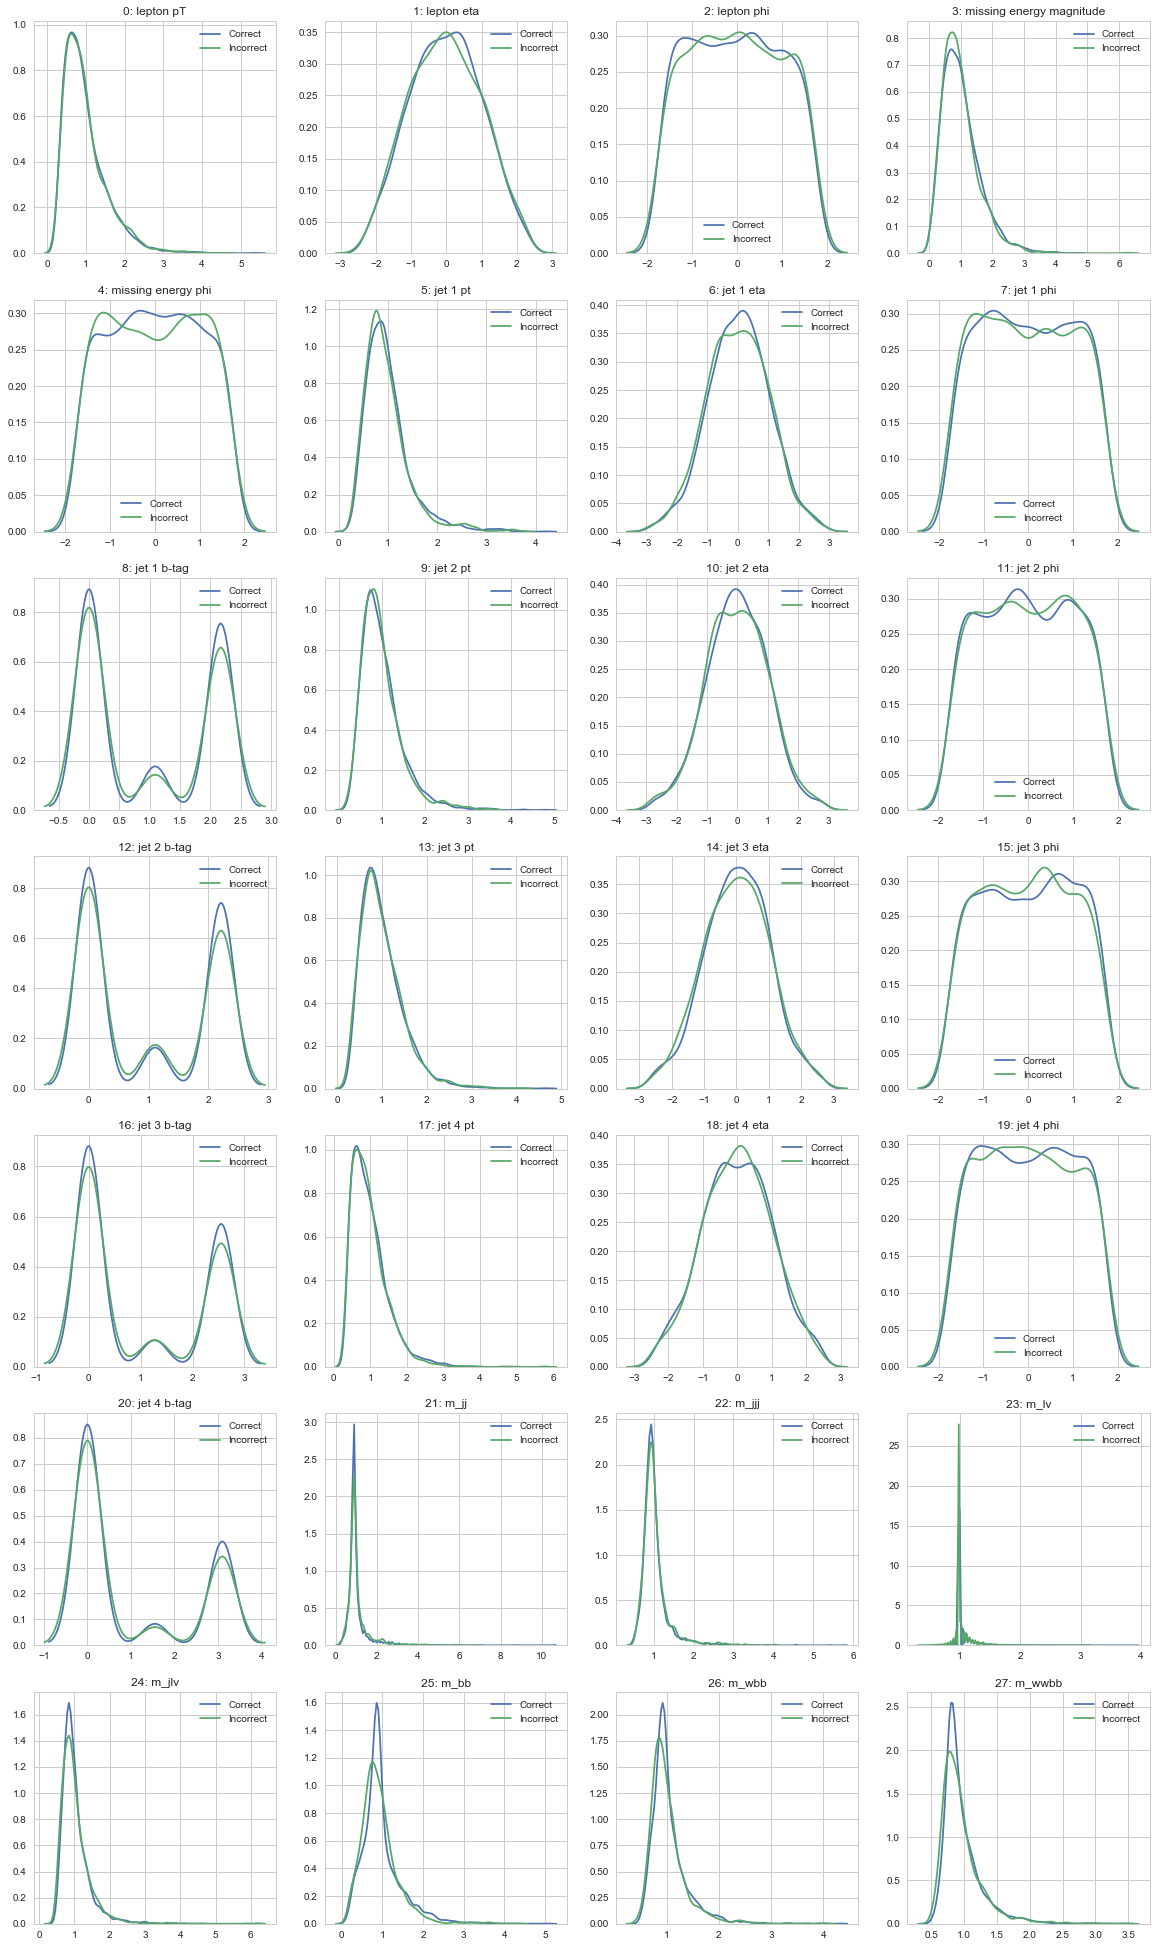

In [19]:
#Plot distribution for correct and incorrect predictions
fig, axs = plt.subplots(nrows=7, ncols=4, figsize=(4*5, 7*5))
for dim, ax in enumerate(axs.ravel()):
    ax.set(title=f"{dim}: {data_train.columns[dim]}")
    sns.kdeplot(X_train[predicted_correctly][:,dim], label="Correct", ax=ax)
    sns.kdeplot(X_train[~predicted_correctly][:,dim], label="Incorrect", ax=ax)

Most predictors have substantially different distributions. The differences are especially pronounced in all the the `phi` predictors (different shapes) and many of the high-level predictors (the ones starting with `m_`, where the main peak is sharper for the correctly predicted examples.

**4.2**

The intended functionality is the following:
1. Fit `tree1`, a decision tree with max depth 3.
2. Construct an array of sample weights. Give a weight of 1 to samples that `tree1` classified correctly, and 2 to samples that `tree1` misclassified.
3. Fit `tree2`, another depth-3 decision tree, using those sample weights.
4. To predict, compute the probabilities that `tree1` and `tree2` each assign to the positive class. Take the average of those two probabilities as the prediction probability.

In [20]:
def boostmeup():
    tree = DecisionTreeClassifier(max_depth=3)
    tree1 = tree.fit(X_train, y_train)
    sample_weight = np.ones(len(X_train))
    q = 0
    for idx in range(len(X_train)):
      if tree1.predict([X_train[idx]]) != y_train[idx]:
         sample_weight[idx] = sample_weight[idx] * 2
         q = q + 1
    print("tree1 accuracy:", q / len(X_train))
    tree2 = tree.fit(X_train, y_train, sample_weight=sample_weight)
    
# Train
    q = 0
    for idx in range(len(X_train)):
        t1p = tree1.predict_proba([X_train[idx]])[0][1]
        t2p = tree2.predict_proba([X_train[idx]])[0][1]
        m = (t1p + t2p) / 2
        if m > .5:
            if y_train[idx] == True:
                q = q + 0
            else:
                q = q + 1
        else:
            if y_train[idx] == True:
                q = q + 1
            else:
                q = 0
    print("Boosted accuracy:", q / len(X_train))

# Test
    q = 0
    for idx in range(len(X_test)):
        t1p = tree1.predict_proba([X_test[idx]])[0][1]
        t2p = tree2.predict_proba([X_test[idx]])[0][1]
        m = (t1p + t2p) / 2
        if m > .5:
            if y_train[idx] == True:
                q = q + 0
            else:
                q = q + 1
        else:
            if y_train[idx] == True:
                q = q + 1
            else:
                q = 0
    print("Boosted accuracy:", q / len(X_test))

boostmeup()

tree1 accuracy: 0.3582
Boosted accuracy: 0.0008
Boosted accuracy: 0.002


As a grader:

Functionality issues :
- `tree1` and `tree2` are actually the same.
- Training Set is used in predicting the Test Set.
- Accuracies are reported backwards.
- num_incorrect is set to 0.

Stylistic issues :
- Function uses global data variables.
- Code duplicated between train and test predictions.
- Prediction logic more complex than necessary.
- Variable names not descriptive.
- Could use vectorized operations.
- Function name is useless.
- Indentation is wonky.
- Can't reuse trained model outside the function.

In [21]:
#Corrected Boosting Code

#Function to Train
def train_simple_boosting(X_train, y_train):
    tree1 = DecisionTreeClassifier(max_depth=3)
    tree1 = tree1.fit(X_train, y_train)
    tree1_predictions = tree1.predict(X_train)
    tree1_incorrect = tree1_predictions != y_train
    sample_weight = np.ones(len(X_train))
    sample_weight[tree1_incorrect] *= 2
    tree2 = DecisionTreeClassifier(max_depth=3).fit(X_train, y_train, sample_weight=sample_weight)
    return tree1, tree2

#Function to predict
def predict_simple_boosting(tree1, tree2, X):
    predictions = [tree.predict_proba(X)[: ,1] for tree in [tree1, tree2]]
    mean_prediction = np.mean(predictions, axis=0)
    assert len(mean_prediction) == len(X)
    return mean_prediction > .5

#Train and Evaluate
tree1, tree2 = train_simple_boosting(X_train, y_train)
print("Base Classifier: Train = {:.3f}, Test = {:.3f}.".format(
    accuracy_score(y_train, tree1.predict(X_train)),
    accuracy_score(y_test, tree1.predict(X_test)),))
print("Simple Boosting Accuracy: Train = {:.3f}, Test = {:.3f}.".format(
    accuracy_score(y_train, predict_simple_boosting(tree1, tree2, X_train)),
    accuracy_score(y_test, predict_simple_boosting(tree1, tree2, X_test)),))

Base Classifier: Train = 0.642, Test = 0.644.
Simple Boosting Accuracy: Train = 0.649, Test = 0.651.


**4.3**

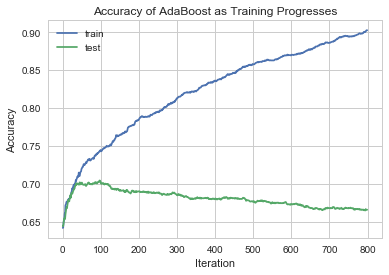

In [22]:
#Fit AdaBoost Model with given specifications
fitted_ada = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=3),
    n_estimators=800,
    learning_rate=.05).fit(X_train,y_train)
train_scores = list(fitted_ada.staged_score(X_train, y_train))
test_scores = list(fitted_ada.staged_score(X_test, y_test))

#Plot Stage Scores
plt.plot(train_scores,label='train')
plt.plot(test_scores,label='test')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title("Accuracy of AdaBoost as Training Progresses")
plt.legend();

**4.4**

In [24]:
#Fit AdaBoost models to each depth
clfs, train_scores, test_scores  = {}, {}, {}
for depth in (1,2,3,4):
    fitted_ada = AdaBoostClassifier(
        base_estimator=DecisionTreeClassifier(max_depth=depth),
        n_estimators=800,
        learning_rate=.05).fit(X_train, y_train)
    train_scores[depth] = list(fitted_ada.staged_score(X_train, y_train))
    test_scores[depth] = list(fitted_ada.staged_score(X_test, y_test))
    clfs[depth] = fitted_ada

Text(0.5,0.98,'Accuracy of AdaBoost as Training Progresses')

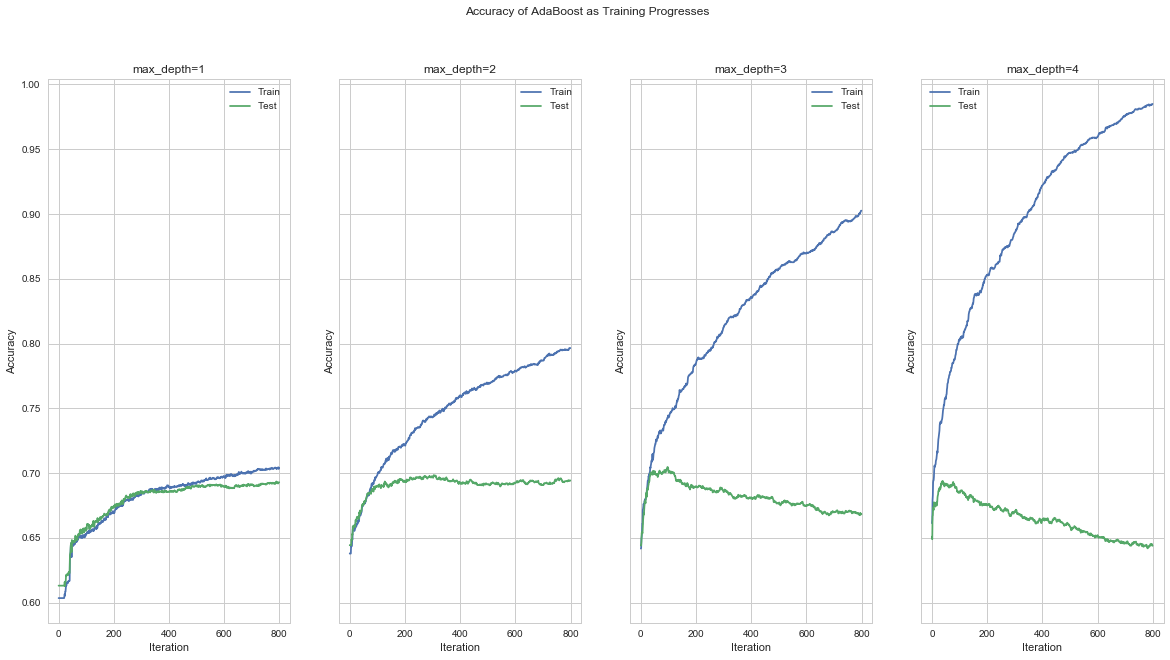

In [25]:
#Plot staged scores for each model
fig, axs = plt.subplots(1, 4, figsize=(20,10), sharey=True)
for ax, depth in zip(axs, (1,2,3,4)):
    ax.plot(train_scores[depth], label='Train')
    ax.plot(test_scores[depth], label='Test')
    ax.set(xlabel='Iteration', ylabel='Accuracy', title=f"max_depth={depth}")
    ax.legend()
plt.suptitle("Accuracy of AdaBoost as Training Progresses")

**4.5**

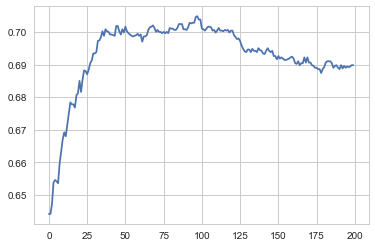

In [26]:
#Best Model Depth-Iteration Combination
plt.plot(test_scores[3][:200]);

A model with depth 2 and about 90-100 iterations seems optimal, as that combination has very similar test and train performance, indicating the model has not overfit. However, other settings (e.g. depth-3 learners and about 75 iterations) achieve higher test accuracy and could be good choices if you trust that the test set is representative of future data.

If we use about 50 depth-3 learners, we get test-set performance of about 0.70, which is better than any of the ensembles we considered earlier. But the result was very much at risk of overfitting: we didn't choose this parameter by cross-validation, so we may be overfitting to this test set.

<div class="exercise"> <b> Question 5: Understanding [15 pts]</b> </div>

This question is an overall test of your knowledge of this homework's material. You may need to refer to lecture notes and other material outside this homework to answer these questions.



**5.1** How do boosting and bagging relate: what is common to both, and what is unique to each?


**5.2** Reflect on the overall performance of all of the different classifiers you have seen throughout this assignment. Which performed best? Why do you think that may have happened?

**5.3** What is the impact of having too many trees in boosting and in bagging? In which instance is it worse to have too many trees?

**5.4** Which technique, boosting or bagging, is better suited to parallelization, where you could have multiple computers working on a problem at the same time?

**5.5** Which of these techniques can be extended to regression tasks? How?

# Solution

**5.1**

- Bagging and Boosting are special cases of Ensembling. 
- In bagging, each model is trained on a fresh bootstrap of the original data: each model is independent. 
- In boosting, each model is trained on a re-weighted copy of the original data where points that are presently being mispredicted get more weight; each model depends on how all of the previous models performed.

**5.2**

Comparing the different classifiers on Test Set accuracy, `AdaBoostClassifier` (depth=2, iterations=100) performs best. This seems intuitive because with each model from the beginning we added predictive power (reduced bias) and reduced variance. 

- Simple Decision trees underfit so Bagging included multiple trees.

- Bagging Trees were highly correlated so we created a Random Forest model.

- AdaBoost then used multiple Decision Trees to consecutively fit the residuals left by the previous Decision Tree.

- Finally, by limiting the number of estimators and depth, we were able to find our sweet spot between performance and robustness i.e. the bias-variance tradeoff. 

**5.3**

- Having too many trees in Bagging isn't much of an issue since test performance will plateau. 
- In contrast, running Boosting for too long will begin to overfit the data and hurt the overall accuracy.
- Thus, it is worse in Boosting.

**5.4**

- Bagging is much better suited to parallelization. 
- In bagging we can train the N models independently, while in boosting we have to wait for the Nth model to finish fitting before we can train the N+1st model.

**5.5**

- All of the models/techniques discussed are extensible to Regression tasks. 
- Instead of making splits in Decision Trees based on resultant purity of subsets, we can calculate resultant MSE of subsets.


<div class="exercise"> <b> Question 6: Explaining Complex Concepts Clearly [10 pts]</b> </div>

One of the core skills of a data scientist is to be able to explain complex concepts clearly. To practice this skill, you'll make a short presentation of one of the approaches we have recently studied.

**Choose one of the following topics:**

- Decision Trees
- Random Forests
- Bagging
- Boosting
- Simple Neural Nets (like the MLP we saw in Homework 6)
- (other topics are possible, but get staff approval first)

**Make 3 slides explaining the concept.**

- Focus on **clear explanations**, NOT aesthetic beauty. Photos of pen-and-paper sketches are fine if they're legible.
- For your audience, choose **future CS109A students**.
- You may take inspiration from anywhere, but explain in **your own words** and **make your own illustrations**.


Submit your slides as a PDF and the source format (`.pptx`, Google Slides, etc.)

NOTE: If you would be okay with us using your slides for future classes (with attribution, of course), please include a note to that effect. This will not affect your grade either way.

# **Solution** : 

We already showed our solution to this section, it's called "Lectures" :)


The rubric used to judge this section however was:

- Did the student define the model/technique? The problem it solves, Regression/Classification/Both? (What? Why?)
- Did the student illustrate the functionality through diagrams or psuedocode or equivalent? (How?)
- Did the student discuss advantages/drawbacks of using it to different problems? (Where/When?)
- Given the audience, was the presentation technical yet simple to interpret? (Presence of Mind?)
- Does the presentation have good structure and maintains a high content to ink ratio? (Efficiency of ink?)